<span style="color:Red">Warning: Do not use "run all" on this notebook without verifying that hardware requirements have been met.</span>

# Background

nVidia and AMD are major fabless chip designers. nVidia is more GPU focused than AMD, but up until Spring 2022 (with the entry of Intel Arc GPUs), the GPU market has been an AMD - nVidia duopoly since around the year 2000 with the exit of pioneers such as 3dfx.

For many years, AMD has been seen as the "budget option", with their GPUs retailing at lower prices than nVidia GPUs of similar performance. In terms of CPUs, AMD fell far behind nVidia and consigned us to years of being stuck with quad core CPUs as Intel lost their willingness to innovate. This changed with the introduction of chiplets in Ryzen CPUs. AMD is now attempting to break away from monolithic designs in their GPUs as well with RDNA3. 

However, the market perception of AMD being the weaker budget option still persists, and users constantly complain about driver issues.

# Problem Statement

## AUDIENCE:

AMD Strategic Planners (Consumer GPUs)

## PROBLEM:

As stated above, there is a perception that AMD's consumer GPUs are inferior to nVidia's consumer GPUs.

It is unclear whether the perception of AMD products being more problematic is a marketing or an engineering issue. If it is genuinely an engineering issue, we would expect to see many more negative posts on r/amd than r/nvidia. If the negative posts are similar, then it is likely a marketing issue. The theory is as follows:

1. Both subreddits are moderated - negative posts such as "amd sucks" without specific reference to a problem the poster is facing gets removed.

2. We would therefore only expect there to be negative posts about actual problems.

3. If a higher proportion of posts on r/amd is negative than on r/nvidia, then it is likely that there is a genuine issue with AMD QA, which should be addressed.

4. If a similar proportion of posts on both subreddits are negative, then it is a perception issue which can be corrected by the deployment of marketing resources.

## OBJECTIVES:

1. The model has to be able to differentiate between comments about AMD and nVidia for more widespread deployment (in the event that becomes necessary).

2. The same data can be used to determine where (marketing or engineering) AMD should deploy resources to improve the perception of their product (see problem above).

## SCOPE:

1. Use text data posted to Reddit on the r/amd and r/nvidia subreddits to build a model to differentiate between text about AMD and text about nVidia. 

2. The purpose of modelling is to be able to use the model on other GPU discussion forums with no split between posts about AMD/nVidia in order to apply the same sentiment analysis tools we are applying to the Reddit dataset.

3. Use sentiment analysis tools to establish whether the perception is driven by nVidia's mindshare or by a genuine engineering problem.
 
## DATA:

1. Titles, descriptions, and comments posted to r/amd and r/nvidia.

## METHODS AND TOOLS:

1. Naive Bayes.

2. Random Forest.

3. Boosted Models.

4. Simple Sequential Neural Network.

## SUCCESS METRICS:

1. Precision.

2. Sentiment Analysis.

# SUCCESS METRICS REASONING

1. Precision is to be the primary method of determining the quality of the model. This is because the main concern for us is to successfully pick out posts concerning AMD in order to apply sentiment analysis tools to them. This means we will be focusing on predictions of "AMD" and will apply sentiment analysis tools on all such predictions when the model is deployed "out in the wild". Accordingly, we want as many of these predictions to be accurate as possible. 

2. Sentiment analysis is to be used to determine the number of negative posts made. The proportion is important as it shows the proportion of people who have faced a problem with AMD hardware. This of course, relies on the assumption that each negative post is an AMD user who has faced a problem with AMD hardware. This assumption is justifiable as r/amd is a forum for AMD users, and users posting negative comments on there are likely to be complaining about AMD hardware they have purchased, relating to the use of such hardware in a video game or otherwise. Users are not likely to be complaining about an nVidia software bug in r/amd.

In [1]:
import pandas as pd
import gensim.utils
import swifter
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from torch import nn
from torch import optim
from torch import tensor
from torchmetrics.classification import BinaryStatScores
from nltk import word_tokenize, ngrams
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
torch.__version__


e:\GA DSIF\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


e:\GA DSIF\.venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


'2.0.1+cu118'

# Data was scraped using main.py.

This was a straightforward process. Essentially, it was simply a matter of applying the praw library and saving the results as csv files for pandas operations in this notebook.

In [2]:
nv_df = pd.read_csv("nvidia_scrape.csv")
amd_df = pd.read_csv("amd_scrape.csv")

# Data Cleaning

In [3]:
nv_df.head()

,title,selftext,comment
0,What Gpu?,My son wants to upgrade his GPU to play more g...,Starfield runs like crap on even the most expe...
1,What Gpu?,My son wants to upgrade his GPU to play more g...,Oh ok! Thank you
2,What Gpu?,My son wants to upgrade his GPU to play more g...,My son just said that Nvidia one’s are more co...
3,"Which graphics card is better and why? (2080, ...",So I recently downloaded Starfield and I notic...,3070 > 2080 > 4060 > 3060\n\nThe first numbers...
4,"Which graphics card is better and why? (2080, ...",So I recently downloaded Starfield and I notic...,The 3070 is far and away the fastest among the...


In [4]:
amd_df.head()

,title,selftext,comment
0,HYPR-RX and RDNA 1-2,Gotta say I'm kinda bummed out to see it come ...,"At least for now, anti-lag+ and AFMF require a..."
1,HYPR-RX and RDNA 1-2,Gotta say I'm kinda bummed out to see it come ...,"According to notes, they plan to add it to old..."
2,HYPR-RX and RDNA 1-2,Gotta say I'm kinda bummed out to see it come ...,HYPER-RX is just a single toggle that enabled ...
3,HYPR-RX and RDNA 1-2,Gotta say I'm kinda bummed out to see it come ...,AMD has a long history of rolling things out a...
4,HYPR-RX and RDNA 1-2,Gotta say I'm kinda bummed out to see it come ...,"Just be patient, there's absolutely nothing pr..."


In [5]:
nv_title_df = pd.DataFrame(nv_df["title"].unique())
nv_title_df

,0
0,What Gpu?
1,"Which graphics card is better and why? (2080, ..."
2,PSA for DLSS with Starfield: Set a negative lo...
3,Currently have a 2070s - Worth it to upgrade t...
4,Which RTX 4080 GPU is best to buy now for $109...
...,...
920,Picked up Zotac RTX 3070 Twin Edge OC 8G from ...
921,gsync is confusing can anyone help? pg259qnr m...
922,Feedback on Gigabyte 4090 OC 24G
923,Which rtx 4070 model to choose - Palit JetStre...


In [6]:
nv_selftext_df = pd.DataFrame(nv_df["selftext"].unique())
nv_selftext_df

,0
0,My son wants to upgrade his GPU to play more g...
1,So I recently downloaded Starfield and I notic...
2,Bethesda/AMD fucked up and didn't set a negati...
3,I'm looking around and seeing a few sales on t...
4,NaN
...,...
808,"I'm mainly writing this post, because I though..."
809,"hey so i play on a 360hz pg259qnr, i thought i..."
810,Looking into getting this card.....\n\n\- Do I...
811,"Hi, I am unable to decide between these two RT..."


In [7]:
nv_content_df = pd.concat([nv_title_df, nv_selftext_df], ignore_index=True)
nv_content_df.reset_index()
nv_content_df.dropna(inplace=True)
nv_content_df

,0
0,What Gpu?
1,"Which graphics card is better and why? (2080, ..."
2,PSA for DLSS with Starfield: Set a negative lo...
3,Currently have a 2070s - Worth it to upgrade t...
4,Which RTX 4080 GPU is best to buy now for $109...
...,...
1733,"I'm mainly writing this post, because I though..."
1734,"hey so i play on a 360hz pg259qnr, i thought i..."
1735,Looking into getting this card.....\n\n\- Do I...
1736,"Hi, I am unable to decide between these two RT..."


In [8]:
amd_title_df = pd.DataFrame(amd_df["title"].unique())
amd_title_df

,0
0,HYPR-RX and RDNA 1-2
1,Starfield New Atlantis 4k Ultra Ryzen 9 7950X ...
2,Anyone ever use ptm7950?
3,Why Is my PRO Driver running way better than A...
4,From a GTX 1060 6GB to 6700XT: 6 Months After
...,...
861,AMD driver Recording
862,Red Devil Ultimate RX 6900 XT Best Thermal Paste?
863,ETA on 780m Drivers?
864,B550 5800x - Does everyone had Tpm stutter in ...


In [9]:
amd_selftext_df = pd.DataFrame(amd_df["selftext"].unique())
amd_selftext_df

,0
0,Gotta say I'm kinda bummed out to see it come ...
1,NaN
2,"Just curious, not that my hardware needs it bu..."
3,Just recently made a PC with a RX 6800 and 580...
4,I was worried about driver issues and I had se...
...,...
499,Is anyone experiencing audio and video off by ...
500,"Hi,\n\nI have the mentioned card in the title...."
501,"We've been waiting for months, can we get an u..."
502,"I got a b550 gaming plus, Iupdated to latest b..."


In [10]:
amd_content_df = pd.concat([amd_title_df, amd_selftext_df], ignore_index=True)
amd_content_df.reset_index()
amd_content_df.dropna(inplace=True)
amd_content_df

,0
0,HYPR-RX and RDNA 1-2
1,Starfield New Atlantis 4k Ultra Ryzen 9 7950X ...
2,Anyone ever use ptm7950?
3,Why Is my PRO Driver running way better than A...
4,From a GTX 1060 6GB to 6700XT: 6 Months After
...,...
1365,Is anyone experiencing audio and video off by ...
1366,"Hi,\n\nI have the mentioned card in the title...."
1367,"We've been waiting for months, can we get an u..."
1368,"I got a b550 gaming plus, Iupdated to latest b..."


In [11]:
nv_content_df["label"] = "nvidia"
nv_content_df.rename(columns={0: "content"}, inplace=True)
nv_content_df.head()

,content,label
0,What Gpu?,nvidia
1,"Which graphics card is better and why? (2080, ...",nvidia
2,PSA for DLSS with Starfield: Set a negative lo...,nvidia
3,Currently have a 2070s - Worth it to upgrade t...,nvidia
4,Which RTX 4080 GPU is best to buy now for $109...,nvidia


In [12]:
nv_content_df.shape

(1737, 2)

In [13]:
amd_content_df["label"] = "amd"
amd_content_df.rename(columns={0: "content"}, inplace=True)
amd_content_df.head()

,content,label
0,HYPR-RX and RDNA 1-2,amd
1,Starfield New Atlantis 4k Ultra Ryzen 9 7950X ...,amd
2,Anyone ever use ptm7950?,amd
3,Why Is my PRO Driver running way better than A...,amd
4,From a GTX 1060 6GB to 6700XT: 6 Months After,amd


In [14]:
amd_content_df.shape

(1369, 2)

In [15]:
nv_content_df["content_clean"] = nv_content_df["content"].apply(lambda x: gensim.utils.simple_preprocess(str(x)))
amd_content_df["content_clean"] = amd_content_df["content"].apply(lambda x: gensim.utils.simple_preprocess(str(x)))

In [16]:
nv_content_df

,content,label,content_clean
0,What Gpu?,nvidia,"[what, gpu]"
1,"Which graphics card is better and why? (2080, ...",nvidia,"[which, graphics, card, is, better, and, why]"
2,PSA for DLSS with Starfield: Set a negative lo...,nvidia,"[psa, for, dlss, with, starfield, set, negativ..."
3,Currently have a 2070s - Worth it to upgrade t...,nvidia,"[currently, have, worth, it, to, upgrade, to, ti]"
4,Which RTX 4080 GPU is best to buy now for $109...,nvidia,"[which, rtx, gpu, is, best, to, buy, now, for,..."
...,...,...,...
1733,"I'm mainly writing this post, because I though...",nvidia,"[mainly, writing, this, post, because, thought..."
1734,"hey so i play on a 360hz pg259qnr, i thought i...",nvidia,"[hey, so, play, on, hz, pg, qnr, thought, it, ..."
1735,Looking into getting this card.....\n\n\- Do I...,nvidia,"[looking, into, getting, this, card, do, need,..."
1736,"Hi, I am unable to decide between these two RT...",nvidia,"[hi, am, unable, to, decide, between, these, t..."


In [17]:
amd_content_df

,content,label,content_clean
0,HYPR-RX and RDNA 1-2,amd,"[hypr, rx, and, rdna]"
1,Starfield New Atlantis 4k Ultra Ryzen 9 7950X ...,amd,"[starfield, new, atlantis, ultra, ryzen, and, ..."
2,Anyone ever use ptm7950?,amd,"[anyone, ever, use, ptm]"
3,Why Is my PRO Driver running way better than A...,amd,"[why, is, my, pro, driver, running, way, bette..."
4,From a GTX 1060 6GB to 6700XT: 6 Months After,amd,"[from, gtx, gb, to, xt, months, after]"
...,...,...,...
1365,Is anyone experiencing audio and video off by ...,amd,"[is, anyone, experiencing, audio, and, video, ..."
1366,"Hi,\n\nI have the mentioned card in the title....",amd,"[hi, have, the, mentioned, card, in, the, titl..."
1367,"We've been waiting for months, can we get an u...",amd,"[we, ve, been, waiting, for, months, can, we, ..."
1368,"I got a b550 gaming plus, Iupdated to latest b...",amd,"[got, gaming, plus, iupdated, to, latest, bios..."


In [18]:
nv_content_df["content_clean_xstopwords"] = nv_content_df["content_clean"].swifter.apply(lambda x: [word for word in x if word not in stopwords.words('english')])

Pandas Apply: 100%|██████████| 1737/1737 [00:12<00:00, 144.71it/s]


In [19]:
amd_content_df["content_clean_xstopwords"] = amd_content_df["content_clean"].swifter.apply(lambda x: [word for word in x if word not in stopwords.words('english')])

Pandas Apply: 100%|██████████| 1369/1369 [00:09<00:00, 148.64it/s]


In [20]:
nv_ser = nv_content_df["content_clean_xstopwords"].squeeze()
nv_ser = nv_ser.explode()

In [21]:
amd_ser = amd_content_df["content_clean_xstopwords"].squeeze()
amd_ser = amd_ser.explode()

In [22]:
nv_text = nv_ser.tolist()
amd_text = amd_ser.tolist()


# EDA - Distributions

In [23]:
nv_fdist = FreqDist(nv_text)

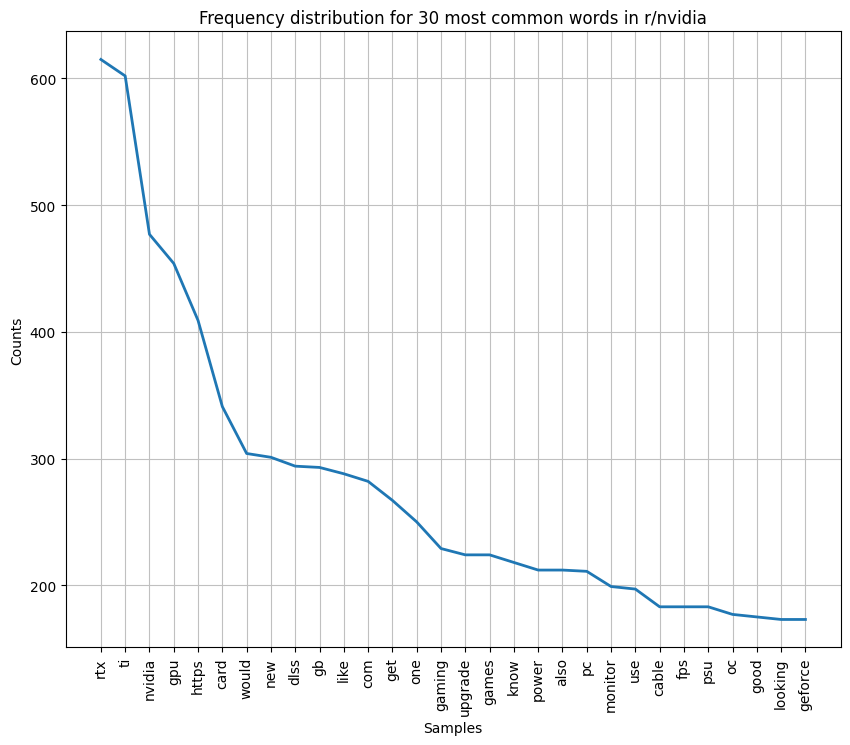

<Axes: title={'center': 'Frequency distribution for 30 most common words in r/nvidia'}, xlabel='Samples', ylabel='Counts'>

In [24]:
plt.figure(figsize=(10,8))
nv_fdist.plot(30, title='Frequency distribution for 30 most common words in r/nvidia')

This is hardly surprising, however it does take some domain knowledge to understand. I will go over a few important entries:

1. rtx - this is the prefix for all of nVidia's consumer GPUs since the Turing Generation.
2. ti - nVidia uses ti in naming certain GPUs. Traditionally, this has been an upgraded version of an existing GPU - see 3080 vs 3080Ti. The community is unsure whether this is related to the Titan line of GPUs which frequently shared the x02 chip with the xx80Ti models but came with professional level drivers.
3. gpu - Graphics Processing Unit, used in the community to either refer to the graphics chip itself or the entire graphics card.
4. card - Refers to the graphics card.
5. dlss - This is DLSS, which stands for Deep Learning Super Sampling. This basically uses a deep learning model to upscale a rendered image from a lower resolution by turning a low resolution image into a high resolution image and filling in the details.
6. fps - Frames Per Second - a metric used to determine the performance of a GPU, the number of frames the GPU generates per second in a certain game at certain graphics settings.
6. psu - Power supply unit - GPUs went from drawing 280W to 350 - 480W between the Turing - Ampere - Lovelace generations, sparking concerns about the adequacy of the then-perfectly-fine 850W PSU.
7. geforce - nVidia name for consumer GPUs.

In [25]:
amd_fdist = FreqDist(amd_text)

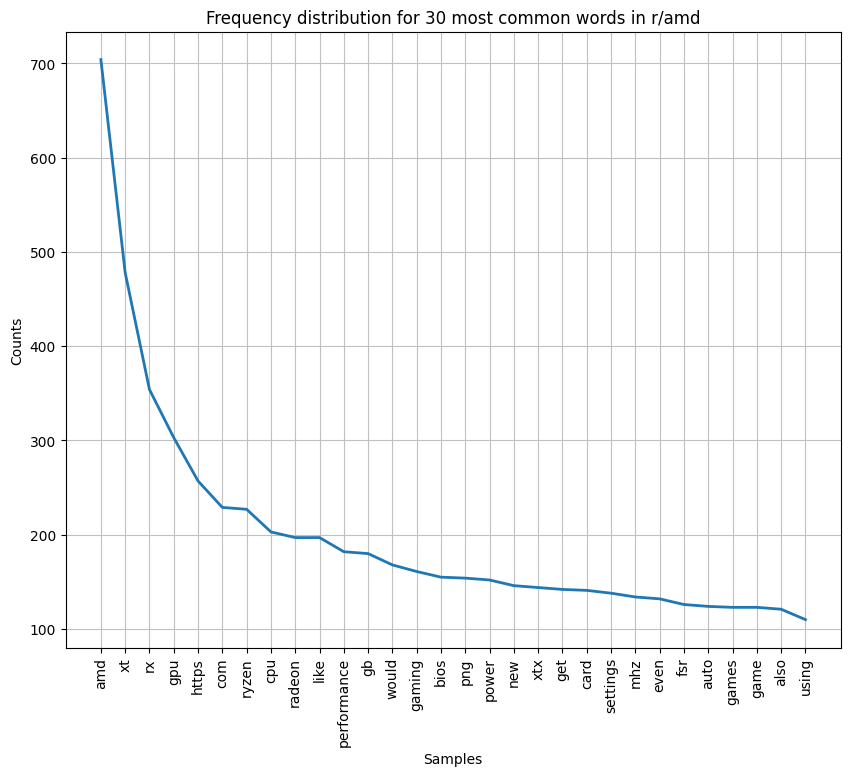

<Axes: title={'center': 'Frequency distribution for 30 most common words in r/amd'}, xlabel='Samples', ylabel='Counts'>

In [26]:
plt.figure(figsize=(10,8))
amd_fdist.plot(30, title='Frequency distribution for 30 most common words in r/amd')

This is interesting, as there are several nVidia proprietary terms here. It will take some domain knowledge to understand. I will go over a few important entries:

1. xt - a common suffix for AMD RDNA (1, 2, and 3) GPUs. See RX6900 XT, RX7900 XT.
2. rx - a common suffic for AMD RDNA (1, 2, and 3) GPUs. See RX6900XT, RX7900XT.
3. ryzen - AMD's line of consumer CPUs. Given that these are widely celebrated by the userbase, this might skew the sentiment analysis in AMD's favour.
4. radeon - AMD's line of GPUs, branding retained from when AMD bought over Ati.
5. power - a recent and frequent complaint was high idle power consumption from AMD GPUs.
6. xtx - Suffix for a higher-spec GPU chip bearing the same number. See RX7900XTX.
7. fsr - AMD's answer to DLSS.

In [27]:
nv_top_30 = [tup[0] for tup in nv_fdist.most_common(30)]
amd_top_30 = [tup[0] for tup in amd_fdist.most_common(30)]

There are lots of common words here - we should take note of them and store them so we can remove them when modelling. So they do not confuse our model.

In [28]:
shared_words = [word for word in nv_top_30 if word in amd_top_30]
shared_words
stop_words = stopwords.words('english')
stop_words = stop_words + shared_words

A good way to show the most common words is the wordcloud.

In [29]:
nv_wordcloud = WordCloud(width=1600, height=800).generate(" ".join([str(word) for word in nv_text]))
amd_wordcloud = WordCloud(width=1600, height=800).generate(" ".join([str(word) for word in amd_text]))

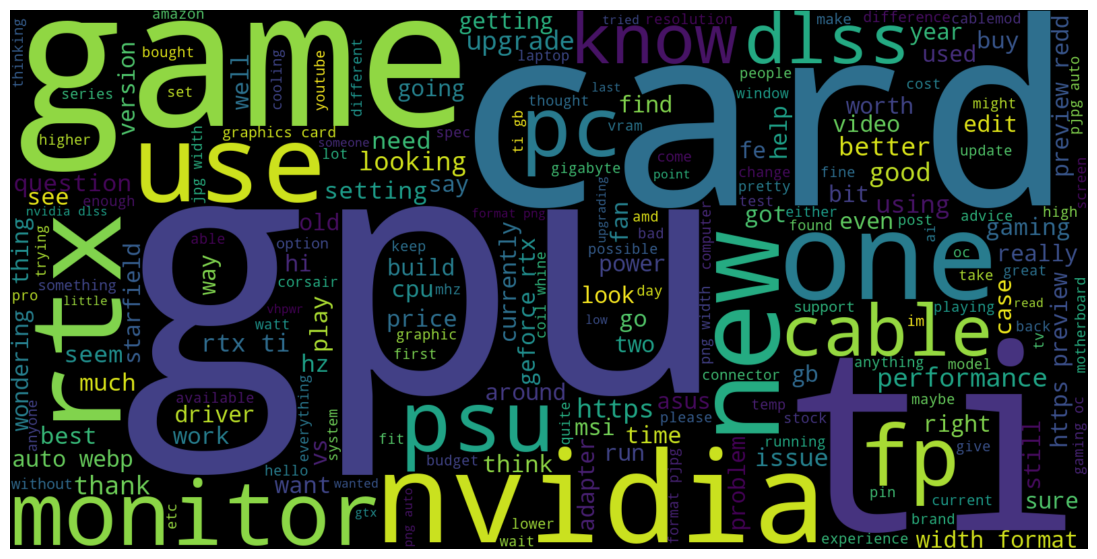

In [30]:
plt.figure(figsize=(14,7))
plt.imshow(nv_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The largest words are what we saw in the frequency distribution earlier. 

1. vhpwr - This refers to the new-ish 12-pin plug that was catching fire at the launch of the Ada Lovelace generation of GPUs. The controversy seems to have died down, indicated by how small that word is.
2. starfield - this is just one game, but somehow it has turned up in here. This is probably due to the fact that it is an AMD sponsored game, which people are likely complaining about. Given the size of the word, it is unlikely to skew the results too much.

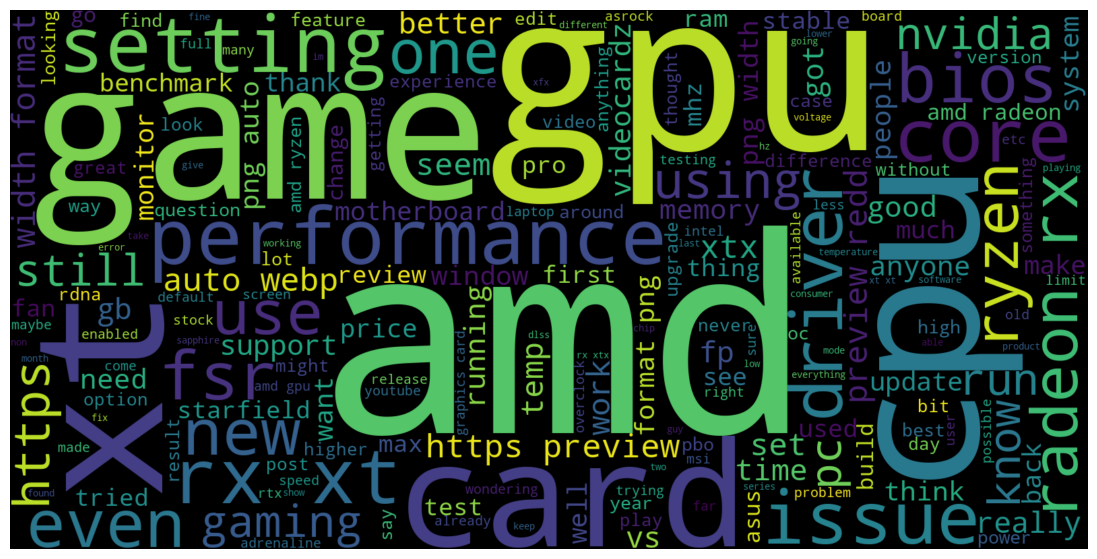

In [31]:
plt.figure(figsize=(14,7))
plt.imshow(amd_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As with nVidia, this largely gives us the same information as the frequency distribution.

Some additional words are worth looking at though:

1. nvidia - it appears that nvidia turns up on r/amd significantly more than amd on r/nvidia.
2. starfield - like with nvidia, but this might skew the results the other way.
3. pbo - precision boost overdrive - AMD's auto-overclock feature, which may slightly skew the results in favour of AMD (again, CPU related).

### Is the data good enough for the problem statement?

Yes, it is. In fact, it is even better than expected since the r/amd is surprisingly heavily skewed towards GPU-related discussions rather than being CPU-related content.



# EDA - N-Grams

In [32]:
nv_list = nv_ser.tolist()

In [33]:
(pd.Series(ngrams(nv_list, 2)).value_counts())[:10]

(https, www)        157
(rtx, ti)           131
(preview, redd)      88
(auto, webp)         88
(width, format)      88
(https, preview)     88
(geforce, rtx)       77
(nvidia, com)        67
(graphics, card)     52
(pjpg, auto)         50
Name: count, dtype: int64

There are a series of words turning up in bigrams here that need to be removed such as https, www, preview, redd, pjpg, and webp. These are all related to websites and/or image previews from images posted to reddit.

In [34]:
(pd.Series(ngrams(nv_list, 3)).value_counts())[:10]

(https, preview, redd)    88
(jpg, width, format)      50
(pjpg, auto, webp)        50
(format, pjpg, auto)      50
(width, format, pjpg)     50
(png, auto, webp)         38
(width, format, png)      38
(format, png, auto)       38
(png, width, format)      38
(https, www, nvidia)      34
Name: count, dtype: int64

The same sort of problems turn up with the trigrams.

In [35]:
amd_list = amd_ser.tolist()

In [36]:
(pd.Series(ngrams(amd_list, 2)).value_counts())[:10]

(rx, xt)             167
(radeon, rx)         117
(preview, redd)       95
(width, format)       95
(auto, webp)          95
(https, preview)      95
(videocardz, com)     84
(png, auto)           70
(format, png)         70
(png, width)          70
Name: count, dtype: int64

AMD bigrams have the same issue as nVidia bigrams.

In [37]:
(pd.Series(ngrams(amd_list, 3)).value_counts())[:10]

(https, preview, redd)    95
(format, png, auto)       70
(png, width, format)      70
(png, auto, webp)         70
(width, format, png)      70
(radeon, rx, xt)          57
(amd, radeon, rx)         40
(jpg, width, format)      25
(format, pjpg, auto)      25
(https, imgur, com)       25
Name: count, dtype: int64

The same issue with websites and images are present, these will need to be added to stop words.

In [38]:
new_stop_words = ["https", "www", "youtube", "com", "redd", "reddit", "preview", "png", "webp", "pjpg", "imgur"]
stop_words = stop_words + new_stop_words

In [39]:
other_stop_words = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'dl', 'doe', 'ha', 'http', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo']
stop_words = stop_words + other_stop_words

# Preparing the Dataframes for modelling

In [40]:
combined_df = pd.concat([nv_content_df, amd_content_df], ignore_index=True)
combined_df.reset_index(inplace=True)
combined_df.shape

(3106, 5)

In [41]:
combined_df = combined_df[["label", "content"]]
combined_df["label"] = combined_df["label"].map({"amd": 1, "nvidia": 0})
combined_df.head() 

,label,content
0,0,What Gpu?
1,0,"Which graphics card is better and why? (2080, ..."
2,0,PSA for DLSS with Starfield: Set a negative lo...
3,0,Currently have a 2070s - Worth it to upgrade t...
4,0,Which RTX 4080 GPU is best to buy now for $109...


In [42]:
combined_df.tail()

,label,content
3101,1,Is anyone experiencing audio and video off by ...
3102,1,"Hi,\n\nI have the mentioned card in the title...."
3103,1,"We've been waiting for months, can we get an u..."
3104,1,"I got a b550 gaming plus, Iupdated to latest b..."
3105,1,Im guessing this is probably the best Im going...


# Missing Values

In [43]:
combined_df.isna().sum()

label      0
content    0
dtype: int64

In [44]:
X = combined_df["content"]
y = combined_df["label"]

# Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Check for imbalance

In [46]:
y_train.value_counts(normalize=True)

label
0    0.559346
1    0.440654
Name: proportion, dtype: float64

# Train data is imbalanced - Bootstrap the 0 label

In [47]:
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)

In [48]:
X_train.head()

785     I read about image scaling a while ago, and ca...
2194    AMD Radeon RX 7900 GRE is now available for €9...
652                                     New 4090 Question
755        How well does the rtx4060ti run on arch linux?
173                                                 VBIOS
Name: content, dtype: object

In [49]:
y_train.head()

785     0
2194    1
652     0
755     0
173     0
Name: label, dtype: int64

In [50]:
train_df = pd.concat([X_train_df, y_train],axis=1)
train_df.head()

,content,label
785,"I read about image scaling a while ago, and ca...",0
2194,AMD Radeon RX 7900 GRE is now available for €9...,1
652,New 4090 Question,0
755,How well does the rtx4060ti run on arch linux?,0
173,VBIOS,0


In [51]:
class_1_df = train_df[train_df["label"] == 1]
class_1_df["label"].value_counts()

label
1    917
Name: count, dtype: int64

In [52]:
class_0_df = train_df[train_df["label"] == 0]
class_0_df["label"].value_counts()

label
0    1164
Name: count, dtype: int64

In [53]:
class_1_df = class_1_df.sample(n=1164, replace=True, random_state=42)

In [54]:
class_1_df["label"].value_counts()

label
1    1164
Name: count, dtype: int64

In [55]:
train_df = pd.concat([class_0_df, class_1_df],axis=0)
train_df.head()

,content,label
785,"I read about image scaling a while ago, and ca...",0
652,New 4090 Question,0
755,How well does the rtx4060ti run on arch linux?,0
173,VBIOS,0
1196,Is it a better idea to go for an RTX 4090 FE a...,0


In [56]:
train_df["label"].value_counts(normalize=True)

label
0    0.5
1    0.5
Name: proportion, dtype: float64

It is now balanced - convert the dataframe back to pandas series for fitting to models.

In [57]:
X_train = train_df["content"]
y_train = train_df["label"]

# Naive Bayes with Count Vectoriser

We'll need a lemmatizer in the pipeline.

In [58]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [59]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [60]:
pipe_params = {
    'cvec__tokenizer': [LemmaTokenizer()],
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__stop_words': [stop_words],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [61]:
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5,
                  scoring="average_precision",
                  n_jobs=-1)

In [62]:
gs.fit(X_train, y_train)

# time - 13s

e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['game'] not in stop_words.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'cvec__tokenizer': [<__main__.LemmaTokenizer object at 0x00000287FCA7DCD0>]},
             scoring='average_precision')

In [63]:
gs.best_score_

0.969471673133692

In [64]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=4000, min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000287FCA8EF10>)),
                ('nb', MultinomialNB())])

In [65]:
gs.score(X_train, y_train)

# time - 24s

0.9907866970980895

In [66]:
gs.score(X_test, y_test)

# time - 9.5s

0.9443883845432376

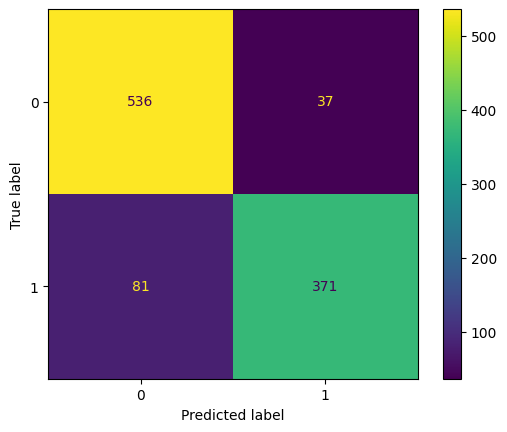

In [67]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 536 accurate predictions of "nvidia", 371 accurate predictions of "amd", 81 incorrect predictions of "nvidia", and 37 incorrect predictions of "amd".

This is out of a total of 1025 predictions made.

In [68]:
cm

array([[536,  37],
       [ 81, 371]], dtype=int64)

In [69]:
# precision
(tp) / (tp + fp)

0.9093137254901961

In [70]:
# recall
(tp) / (tp + fn)

0.8207964601769911

In [71]:
f1_score(y_test, preds)

0.8627906976744186

A precision score of 0.90 is quite good. However, we may be able to do better with other models and it is worth experimenting.

# Naive Bayes with Tfidf Vectoriser

In [72]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [73]:
pipe_tvec_params = {
    'tvec__tokenizer': [LemmaTokenizer()],
    'tvec__max_features': [7000, 8000, 9000],
    'tvec__stop_words': [stop_words],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [74]:
gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid=pipe_tvec_params, 
                        cv=5,
                        scoring="average_precision",
                        n_jobs=-1) 

In [75]:
gs_tvec.fit(X_train, y_train)

# time - 13s

e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['game'] not in stop_words.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [7000, 8000, 9000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'tvec__tokenizer': [<__main__.LemmaTokenizer object at 0x0000028800706C50>]},
             scoring='average_precision')

In [76]:
print(gs_tvec.best_score_)

0.9715337090870294


In [77]:
gs_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=7000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x0000028804EE4290>)),
                ('nb', MultinomialNB())])

In [78]:
gs_tvec.score(X_train, y_train)

0.9931518422183403

In [79]:
gs_tvec.score(X_test, y_test)

0.940986454046002

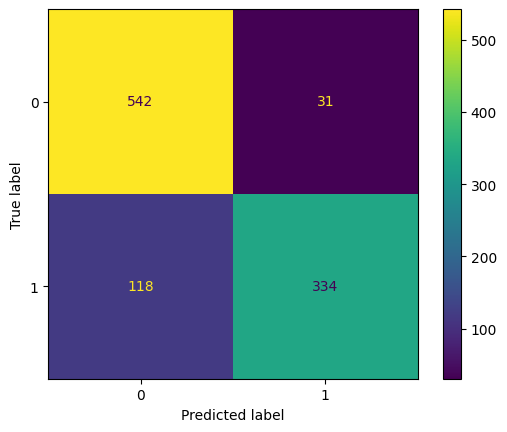

In [80]:
preds_tvec = gs_tvec.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()
cm = confusion_matrix(y_test, preds_tvec)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 545 accurate predictions of "nvidia", 327 accurate predictions of "amd", 125 incorrect predictions of "nvidia", and 28 incorrect predictions of "amd".

This is out of a total of 1205 predictions made.

In [81]:
cm

array([[542,  31],
       [118, 334]], dtype=int64)

In [82]:
# precision
(tp) / (tp + fp)

0.915068493150685

In [83]:
# recall
(tp) / (tp + fn)

0.7389380530973452

In [84]:
f1_score(y_test, preds_tvec)

0.817625458996328

A precision of 0.92 represents an improvement over using cvec. Naive Bayes with the tfidf vectoriser is now the front-runner in terms of model selection.

# Random Forest Classifier with Tfidf Vectoriser

In [85]:
pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [86]:
pipe_rf_params = {
    'tvec__tokenizer': [LemmaTokenizer()],
    'tvec__max_features': [10000, 11000, 12000],
    'tvec__stop_words': [stop_words],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'rf__n_estimators': [150],
    'rf__max_depth': [200],
}
rf_gs = GridSearchCV(pipe_rf, 
                     param_grid=pipe_rf_params,
                     scoring="average_precision", 
                     cv=5, 
                     n_jobs=-1)

In [87]:
rf_gs.fit(X_train, y_train)

# eta 43s

e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['game'] not in stop_words.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [200], 'rf__n_estimators': [150],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [10000, 11000, 12000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'tvec__tokenizer': [<__main__.LemmaTokenizer object at 0x0000028804F5DC50>]},
             scoring='average_precision')

In [88]:
rf_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.95, max_features=12000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x0000028805624810>)),
                ('rf',
                 RandomForestClassifier(max_depth=200, n_estimators=150))])

In [89]:
print(rf_gs.best_score_)

0.9813766339727603


In [90]:
rf_gs.score(X_train, y_train)

0.999919887919611

In [91]:
rf_gs.score(X_test, y_test)

0.9373651748759617

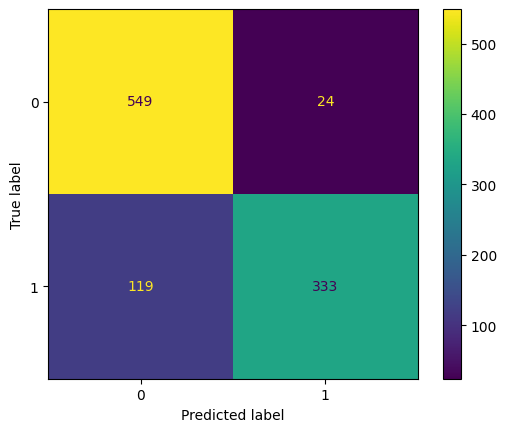

In [92]:
preds_rf = rf_gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()
cm = confusion_matrix(y_test, preds_rf)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 543 accurate predictions of "nvidia", 339 accurate predictions of "amd", 113 incorrect predictions of "nvidia", and 30 incorrect predictions of "amd".

This is out of a total of 1205 predictions made.

In [93]:
cm

array([[549,  24],
       [119, 333]], dtype=int64)

In [94]:
# precision
(tp) / (tp + fp)

0.9327731092436975

In [95]:
# recall
(tp) / (tp + fn)

0.7367256637168141

In [96]:
f1_score(y_test, preds_rf)

0.8232385661310261

This model is overfitted, but has a precision above naive bayes with tfidf. However, performance is a concern as it did take 3 times as long to fit.

# Boosted Models

### Adaboost with Tfidf Vectoriser

In [97]:
pipe_ada = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

In [98]:
pipe_ada_params = {
    'tvec__tokenizer': [LemmaTokenizer()],
    'tvec__max_features': [11000],
    'tvec__stop_words': [stop_words],
    'tvec__ngram_range': [(1,2)],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'ada__n_estimators': [500, 600, 700],
}
ada_gs = GridSearchCV(pipe_ada, 
                     param_grid=pipe_ada_params,
                     scoring="average_precision",  
                     cv=5, 
                     n_jobs=-1)

In [99]:
ada_gs.fit(X_train, y_train)

# eta 1m 2s

e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['game'] not in stop_words.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ada', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'ada__n_estimators': [500, 600, 700],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [11000], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'tvec__tokenizer': [<__main__.LemmaTokenizer object at 0x0000028805627DD0>]},
             scoring='average_precision')

In [100]:
ada_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=11000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000288061C49D0>)),
                ('ada', AdaBoostClassifier(n_estimators=600))])

In [101]:
ada_gs.score(X_train, y_train)

0.9999926281987602

In [102]:
ada_gs.score(X_test, y_test)

0.9126414183957925

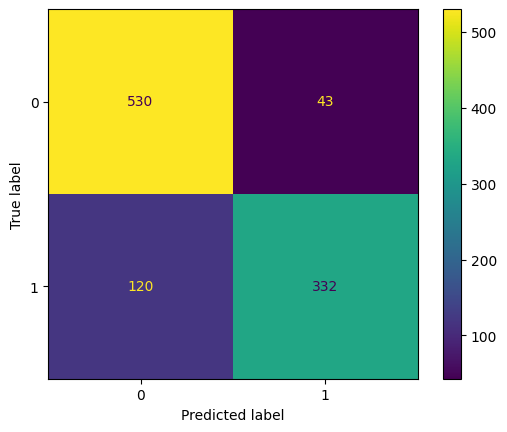

In [103]:
preds_ada = ada_gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_ada).ravel()
cm = confusion_matrix(y_test, preds_ada)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 530 accurate predictions of "nvidia", 332 accurate predictions of "amd", 43 incorrect predictions of "nvidia", and 120 incorrect predictions of "amd".

This is out of a total of 35,065 predictions made.

In [104]:
cm

array([[530,  43],
       [120, 332]], dtype=int64)

In [105]:
# precision
(tp) / (tp + fp)

0.8853333333333333

In [106]:
# recall
(tp) / (tp + fn)

0.7345132743362832

In [107]:
f1_score(y_test, preds_ada)

0.8029020556227328

A precision score of 0.88 is rather poor in comparison to the previous models. Given that we are clearing 0.90 in terms of precision, all models scoring under 0.90 should be eliminated.

### Gradient Boost

In [108]:
pipe_gboost = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gboost', GradientBoostingClassifier())
])

In [109]:
pipe_gboost_params = {
    'tvec__tokenizer': [LemmaTokenizer()],
    'tvec__max_features': [11000],
    'tvec__stop_words': [stop_words],
    'tvec__ngram_range': [(1,2)],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'gboost__n_estimators': [700, 800],
}
gboost_gs = GridSearchCV(pipe_gboost, 
                     param_grid=pipe_gboost_params, 
                     scoring="average_precision", 
                     cv=5, 
                     n_jobs=-1)

In [110]:
gboost_gs.fit(X_train, y_train)

# eta 2m 9s

e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['game'] not in stop_words.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('gboost',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gboost__n_estimators': [700, 800],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [11000], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'tvec__tokenizer': [<__main__.LemmaTokenizer object at 0x00000288068AC8D0>]},
             scoring='average_precision')

In [111]:
gboost_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=11000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000288062AF390>)),
                ('gboost', GradientBoostingClassifier(n_estimators=800))])

In [112]:
gboost_gs.score(X_train, y_train)

0.9999087002652696

In [113]:
gboost_gs.score(X_test, y_test)

0.9369643096610026

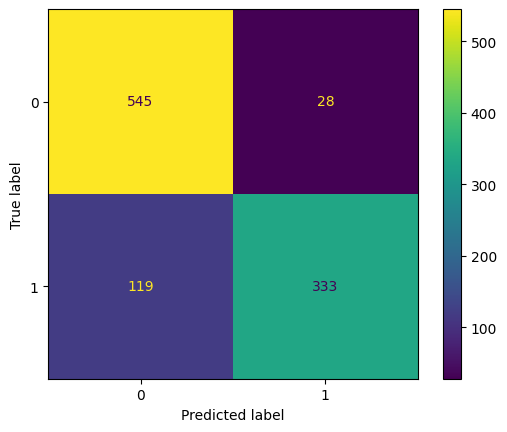

In [114]:
preds_gboost = gboost_gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gboost).ravel()
cm = confusion_matrix(y_test, preds_gboost)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 545 accurate predictions of "nvidia", 333 accurate predictions of "amd", 119 incorrect predictions of "nvidia", and 28 incorrect predictions of "amd".

This is out of a total of 1205 predictions made.

In [115]:
cm

array([[545,  28],
       [119, 333]], dtype=int64)

In [116]:
# precision
(tp) / (tp + fp)

0.9224376731301939

In [117]:
# recall
(tp) / (tp + fn)

0.7367256637168141

In [118]:
f1_score(y_test, preds_gboost)

0.8191881918819188

At 0.92, the precision score of this model equals Naive Bayes with tfidf. However, it did take 3 times as long to fit which is not ideal.

# XGBoost

In [119]:
pipe_xgboost = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

In [120]:
pipe_xgboost_params = {
    'tvec__tokenizer': [LemmaTokenizer()],
    'tvec__max_features': [11000],
    'tvec__stop_words': [stop_words],
    'tvec__ngram_range': [(1,2)],
    'tvec__min_df': [2],
    'tvec__max_df': [.9],
    'xgb__learning_rate': [0.05],
    'xgb__n_estimators': [1000],
    'xgb__max_depth': [200],
    'xgb__min_child_weight': [1],
    'xgb__gamma': [0],
    'xgb__subsample': [0.8],
    'xgb__objective': ['binary:logistic'],
    'xgb__device': ['cuda'],
    'xgb__tree_method': ['hist'], # if enabling cuda, use 'hist'
}

# This takes 5 minutes on with GPU.
# Attempted to run on CPU - no result after 90 minutes.

In [121]:
xgboost_gs = GridSearchCV(pipe_xgboost, 
                          param_grid=pipe_xgboost_params, 
                          scoring="average_precision", 
                          cv=5, 
                          n_jobs=-1)

In [122]:
xgboost_gs.fit(X_train, y_train)

# eta 33s

e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
e:\GA DSIF\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['game'] not in stop_words.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=Non...
                                               'its', 'itself', ...]],
                         'tvec__tokenizer': [<__main__.LemmaTokenizer object at 0x0000028807BD10D0>],
                         'xgb__device': ['cuda'], 'xgb__gamma': [0],
                         'xgb__learning_rate': [0.05], 'xgb__max_depth': [200],
                         'xgb__min_child_weight': [1],
                         'xgb__n_estimators': [1000],
                         'xgb__objective': ['binary:logistic'],
                         'xgb__subsample': [0.8],
                         'xgb__tree_method': ['hist']},
             scoring='average_precision')

In [123]:
xgboost_gs.score(X_train, y_train)

e:\GA DSIF\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.5732996887126522

In [124]:
xgboost_gs.score(X_test, y_test)

0.477388296181985

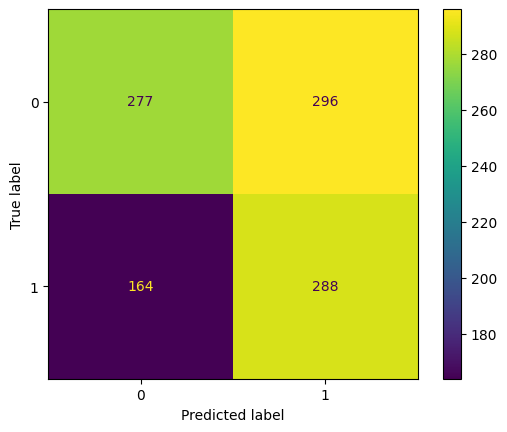

In [125]:
preds_xgboost = xgboost_gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_xgboost).ravel()
cm = confusion_matrix(y_test, preds_xgboost)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 277 accurate predictions of "nvidia", 288 accurate predictions of "amd", 164 incorrect predictions of "nvidia", and 296 incorrect predictions of "amd".

This is out of a total of 1205 predictions made.

In [126]:
cm

array([[277, 296],
       [164, 288]], dtype=int64)

In [127]:
# precision
(tp) / (tp + fp)

0.4931506849315068

In [128]:
# recall
(tp) / (tp + fn)

0.6371681415929203

In [129]:
f1_score(y_test, preds_xgboost)

0.555984555984556

This model is all around awful - it scores worse on just about every metric. It should not be used.

# Simple Sequential Neural Network

In [130]:
vectorizer = TfidfVectorizer(max_features=11000, stop_words="english", ngram_range=(1, 2))

In [131]:
Z_train = vectorizer.fit_transform(X_train)

In [132]:
Z_test = vectorizer.transform(X_test)

In [133]:
Z_train = torch.tensor(scipy.sparse.csr_matrix.todense(Z_train)).float()
Z_test = torch.tensor(scipy.sparse.csr_matrix.todense(Z_test)).float()

In [134]:
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

In [135]:

model = nn.Sequential(nn.Linear(Z_train.shape[1], 64),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(64, combined_df["label"].nunique()),
                      nn.LogSoftmax(dim=1))


In [136]:
# Define the loss
criterion = nn.NLLLoss()

In [137]:
# Forward pass, get our logits
logps = model(Z_train)
# Calculate the loss with the logits and the labels
loss = criterion(logps, y_train_tensor)

In [138]:
loss.backward()

In [139]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [140]:
train_losses = []
test_losses = []
test_accuracies = []

epochs = 150
for epoch in range(epochs):
    optimizer.zero_grad()

    output = model.forward(Z_train)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    optimizer.step()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_ps = model(Z_test)
        test_loss = criterion(log_ps, y_test_tensor)
        test_losses.append(test_loss)

        ps = torch.exp(log_ps)
        tp, tclass = ps.topk(1, dim=1)
        equals = tclass == y_test_tensor.view(*tclass.shape)
        test_accuracy = torch.mean(equals.float())
        test_accuracies.append(test_accuracy)

        best_loss = min(test_losses)

        if test_loss <= best_loss:
            best_model = model.state_dict()

    model.train()

    print(f"Epoch: {epoch+1}/{epochs}.. ",
          f"Training Loss: {train_loss:.3f}.. ",
          f"Test Loss: {test_loss:.3f}.. ",
          f"Test Accuracy: {test_accuracy:.3f}")
    
model.load_state_dict(best_model)

# eta 5s

Epoch: 1/150..  Training Loss: 0.695..  Test Loss: 0.687..  Test Accuracy: 0.559
Epoch: 2/150..  Training Loss: 0.693..  Test Loss: 0.686..  Test Accuracy: 0.559
Epoch: 3/150..  Training Loss: 0.691..  Test Loss: 0.685..  Test Accuracy: 0.559
Epoch: 4/150..  Training Loss: 0.689..  Test Loss: 0.684..  Test Accuracy: 0.559
Epoch: 5/150..  Training Loss: 0.686..  Test Loss: 0.682..  Test Accuracy: 0.559
Epoch: 6/150..  Training Loss: 0.684..  Test Loss: 0.681..  Test Accuracy: 0.559
Epoch: 7/150..  Training Loss: 0.682..  Test Loss: 0.680..  Test Accuracy: 0.559
Epoch: 8/150..  Training Loss: 0.679..  Test Loss: 0.678..  Test Accuracy: 0.559
Epoch: 9/150..  Training Loss: 0.676..  Test Loss: 0.676..  Test Accuracy: 0.559
Epoch: 10/150..  Training Loss: 0.673..  Test Loss: 0.675..  Test Accuracy: 0.559
Epoch: 11/150..  Training Loss: 0.670..  Test Loss: 0.673..  Test Accuracy: 0.560
Epoch: 12/150..  Training Loss: 0.667..  Test Loss: 0.671..  Test Accuracy: 0.560


Epoch: 13/150..  Training Loss: 0.664..  Test Loss: 0.669..  Test Accuracy: 0.560
Epoch: 14/150..  Training Loss: 0.661..  Test Loss: 0.667..  Test Accuracy: 0.563
Epoch: 15/150..  Training Loss: 0.657..  Test Loss: 0.665..  Test Accuracy: 0.573
Epoch: 16/150..  Training Loss: 0.653..  Test Loss: 0.663..  Test Accuracy: 0.582
Epoch: 17/150..  Training Loss: 0.650..  Test Loss: 0.661..  Test Accuracy: 0.593
Epoch: 18/150..  Training Loss: 0.646..  Test Loss: 0.659..  Test Accuracy: 0.607
Epoch: 19/150..  Training Loss: 0.642..  Test Loss: 0.657..  Test Accuracy: 0.628
Epoch: 20/150..  Training Loss: 0.638..  Test Loss: 0.655..  Test Accuracy: 0.649
Epoch: 21/150..  Training Loss: 0.634..  Test Loss: 0.652..  Test Accuracy: 0.674
Epoch: 22/150..  Training Loss: 0.629..  Test Loss: 0.650..  Test Accuracy: 0.692
Epoch: 23/150..  Training Loss: 0.625..  Test Loss: 0.648..  Test Accuracy: 0.703
Epoch: 24/150..  Training Loss: 0.621..  Test Loss: 0.645..  Test Accuracy: 0.719
Epoch: 25/150.. 

<All keys matched successfully>

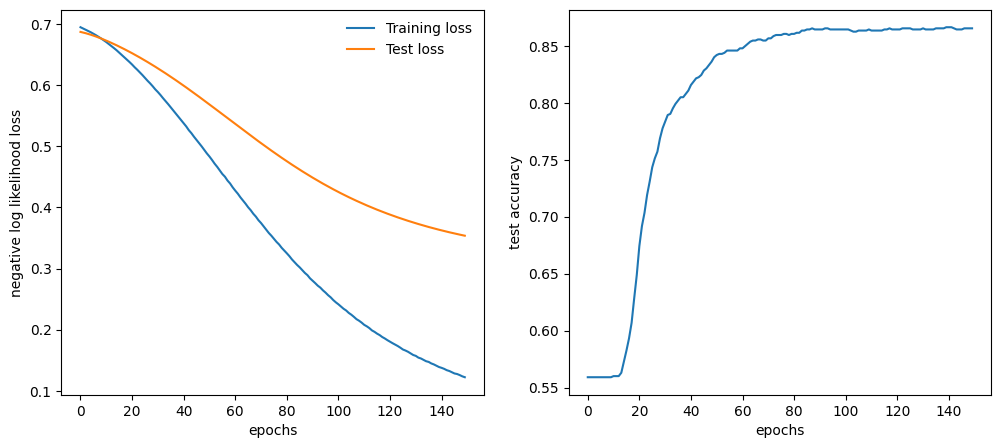

In [141]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('negative log likelihood loss')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(test_accuracies)

The plot on the left shows the negative log loss as the model runs through training epochs. The plot on the right shows test accuracy as the model runs through training epochs. The idea is to reduce the loss as much as possible. The accuracy score against the test data is unfortunately not better than the models we tested above.

In [142]:
pred_torch = model(Z_test)
pred_torch = torch.sigmoid(pred_torch)
pred_torch[0][0].item()

0.47137486934661865

In [143]:
pred_torch_list = []

for pred in pred_torch:
    if pred[0].item() > pred[1].item():
        pred_torch_list.append(0)
    else:
        pred_torch_list.append(1)

pred_torch_srs = pd.Series(pred_torch_list)

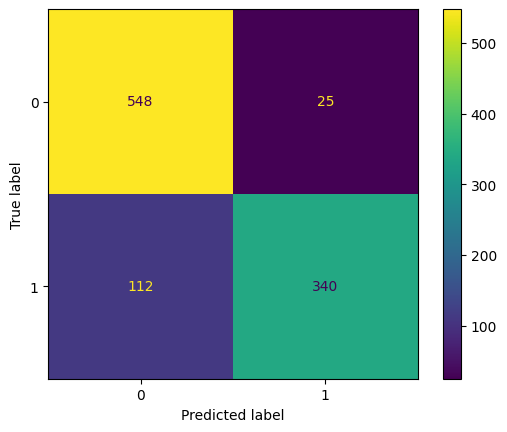

In [144]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_torch_srs).ravel()
cm = confusion_matrix(y_test, pred_torch_srs)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

The above plot indicates the following:

The model produced 548 accurate predictions of "nvidia", 340 accurate predictions of "amd", 112 incorrect predictions of "nvidia", and 25 incorrect predictions of "amd".

This is out of a total of 1205 predictions made.

In [145]:
cm

array([[548,  25],
       [112, 340]], dtype=int64)

In [146]:
# precision
(tp) / (tp + fp)

0.9315068493150684

In [147]:
# recall
(tp) / (tp + fn)

0.7522123893805309

In [148]:
f1_score(y_test, pred_torch_srs)

0.8323133414932681

This gives us the a precision score better than the front-runner, and the the shortest fit time less than half of the front runner. Further, the network can be further improved. It is currently extremely simple consisting of only 1 layer. 

It is however, not as explanainable as Bayes. In addition, it is currently running on nVidia proprietary software as it depends on a library which depends on CUDA. 

# Modelling Conclusions

### Model Performance and Time Taken
|Model|Train Score|Test Score|Precision|Recall|F1-Score|Fit time|
|---|---|---|---|---|---|---|
|Naive Bayes with cvec|0.990|0.944|0.909|0.820|0.862|18s|
|Naive Bayes with tvec|0.993|0.941|0.915|0.739|0.818|14s|
|Random Forest with tvec|0.999|0.937|0.932|0.736|0.823|43s|
|Adaboost with tvec|0.999|0.913|0.885|0.735|0.819|58s|
|Gradient Boost with tvec|0.999|0.937|0.922|0.737|0.819|2m 12s|
|XGBoost with tvec|0.573|0.477|0.493|0.637|0.556|33s (CUDA)|
|Sequential Neural Net with tvec|N/A|0.865|0.931|0.752|0.832|5s (CUDA)|

We will only consider the models with a precision score of 0.90 and above.

The simple sequential neural network is overall the best model. However, there is the issue of it being entirely dependent on nVidia proprietary technology. It would not look for an AMD internal data team to be deploying such a model if word got out. However, if something similar can be implemented using AMD ROCm, the neural network may be the way forward.

In the meantime, despite having a slightly lower precision score, the model to be deployed is Naive Bayes with the Tfidf vectoriser. This is due to the fact that while random forest gets a better score, it also took 3 times as long to fit. In view of the absolute size (3 times Naive Bayes (*emphasis*)) of the total dataset which may need to be processed in the future, considerations about performance win out over the small difference in precision score.

# Sentiment Analysis

In [149]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nv_sent_df = nv_content_df[["content"]]
amd_sent_df = amd_content_df[["content"]]

In [150]:
kowalski = SentimentIntensityAnalyzer()

In [151]:
nv_sent_df.head()

,content
0,What Gpu?
1,"Which graphics card is better and why? (2080, ..."
2,PSA for DLSS with Starfield: Set a negative lo...
3,Currently have a 2070s - Worth it to upgrade t...
4,Which RTX 4080 GPU is best to buy now for $109...


In [152]:
amd_sent_df.head()

,content
0,HYPR-RX and RDNA 1-2
1,Starfield New Atlantis 4k Ultra Ryzen 9 7950X ...
2,Anyone ever use ptm7950?
3,Why Is my PRO Driver running way better than A...
4,From a GTX 1060 6GB to 6700XT: 6 Months After


In [153]:
nv_sent_df["sentiment"] = nv_sent_df["content"].apply(lambda x: kowalski.polarity_scores(x)['compound'])

C:\Users\Morgan\AppData\Local\Temp\ipykernel_7224\568583460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nv_sent_df["sentiment"] = nv_sent_df["content"].apply(lambda x: kowalski.polarity_scores(x)['compound'])


In [154]:
amd_sent_df["sentiment"] = amd_sent_df["content"].apply(lambda x: kowalski.polarity_scores(x)['compound'])

C:\Users\Morgan\AppData\Local\Temp\ipykernel_7224\741008753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_sent_df["sentiment"] = amd_sent_df["content"].apply(lambda x: kowalski.polarity_scores(x)['compound'])


In [155]:
nv_sent_df.head()

,content,sentiment
0,What Gpu?,0.0000
1,"Which graphics card is better and why? (2080, ...",0.4404
2,PSA for DLSS with Starfield: Set a negative lo...,-0.6249
3,Currently have a 2070s - Worth it to upgrade t...,0.2263
4,Which RTX 4080 GPU is best to buy now for $109...,0.7964


In [156]:
amd_sent_df.head()

,content,sentiment
0,HYPR-RX and RDNA 1-2,0.0000
1,Starfield New Atlantis 4k Ultra Ryzen 9 7950X ...,0.0000
2,Anyone ever use ptm7950?,0.0000
3,Why Is my PRO Driver running way better than A...,0.4404
4,From a GTX 1060 6GB to 6700XT: 6 Months After,0.0000


In [157]:
nv_no_of_rows = nv_sent_df.shape[0]

In [158]:
amd_no_of_rows = amd_sent_df.shape[0]

In [159]:
nv_negative_posts = 0

for index, row in nv_sent_df.iterrows():
    if row["sentiment"] < 0:
        nv_negative_posts += 1
    else:
        pass

nv_negative_posts

190

In [160]:
amd_negative_posts = 0

for index, row in amd_sent_df.iterrows():
    if row["sentiment"] < 0:
        amd_negative_posts += 1
    else:
        pass

amd_negative_posts

208

In [161]:
nv_negative_proportion = nv_negative_posts / nv_no_of_rows
amd_negative_proportion = amd_negative_posts / amd_no_of_rows

In [162]:
nv_negative_proportion

0.10938399539435809

In [163]:
amd_negative_proportion

0.15193571950328708

In [164]:
# Difference in proportion of negative comments with the proportion of negative comments on r/nvidia as a baseline:

(amd_negative_proportion - nv_negative_proportion) / nv_negative_proportion

0.3890123409326824

# Sentiment Analysis Conclusions

### Headline Conclusions

1. The percentage of negative posts in r/nvidia is 10.9%.

2. The percentage of negative posts in r/amd is 15.2%.

3. This is a significant difference - For every n comments on r/amd, there are 38.9% more negative comments than for every n comments on r/nvidia.

4. There is likely a genuine issue with AMD products.

### Provisos

1. It is not possible to filter out price-related complaints on r/nVidia. These complaints have been quite common since the major price increase in the RTX xx80 GPUs of the Lovelace generation.

2. Posts relating to AMD CPUs (which have been extremely well received) have not been filtered out. 

3. Given the above, there is likely an even greater difference in technical complaints than 38.9%.

# Recommendations

### Modelling

1. Given that this model is going to be deplyed by AMD, we should use the model which is compatible with AMD's hardware. Therefore, we should use Naive Bayes with the tfidf vectoriser.

2. We are concerned with precision as this metric ensures that subsequent sentiment analysis includes as few non-AMD related posts as possible. This is because the use-case for the model is to pick out AMD-related posts from GPU discussion forums. A precision score of 0.92 from this models is adequate.

3. This model will need to be re-trained as a multi-classification model to take into Intel Arc GPUs into account once they achieve further market penetration.

### Sentiment Analysis

1. Engineering needs to be given more resources to apply towards development for greater driver stability.

2. A good start would be the development and implementation of a comprehensive testing suite before any new graphics driver release.

3. A major difference in AMD / Nvidia user software is the lack of settings available for AMD GPUs. Having more available parameters means users will likely be better able to tune their GPUs for their systems. See: nVidia Control Panel / nVidia Profile Inspector. AMD's GPU software looks modern, compared to nVidia's 90's chic control software, but nVidia's software works, and does not hide settings behind a ton of menus. AMD's software also lacks a the massive number of settings available to nVidia users.

# Required Packages below, not part of report.

In [165]:
import session_info

session_info.show()